In [2]:
import torch
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
import os
import csv
import re
import torch.nn as nn
import torch.optim as optim

print(tf.__version__)
print(tfds.__version__)
print(np.__version__)
print(torch.__version__)
print(pd.__version__)
print(re.__version__)
# print(os.__version__)
print(csv.__version__)

2.19.0
4.9.9
2.0.2
2.8.0+cu126
2.2.2
2.2.1
1.0


In [3]:
HA2EV = 27.211386245988

def def_frontier_gap(ener_a, occ_a, ener_b, occ_b, thr=0.5):
    """
    Compute HOMO-LUMO frontier gap (PBE0) from orbital energies & occupations.
    return value in eV.
    """

    def homo_lumo(e, o):
        homo_idx = np.where(o > thr)[0]
        lumo_idx = np.where(o <= thr)[0]

        homo_e = e[homo_idx.max()] if homo_idx.size else -np.inf
        lumo_e = e[lumo_idx.min()] if lumo_idx.size else np.inf

        return homo_e, lumo_e

    ha, la = homo_lumo(ener_a, occ_a)
    hb, lb = homo_lumo(ener_b, occ_b)

    gap_ha = min(la, lb) - max(ha, hb)

    return gap_ha * HA2EV

In [4]:
QCML_DATA_DIR = 'gs://qcml-datasets/tfds/'

In [5]:
ds = tfds.load(
    'qcml/dft_pbe0_energy',
    split='full[:100000]',
    data_dir=QCML_DATA_DIR,
    download=False
    # read_config=read_config
)

In [6]:
for example in ds.take(1):
    print(f'example: {example}')


example: {'key_hash': <tf.Tensor: shape=(), dtype=string, numpy=b'JuDVURYRCJ8='>, 'pbe0_energy': <tf.Tensor: shape=(), dtype=float64, numpy=-17193.111328125>}


In [7]:
DATASET_CONFIGS = [
    'dft_pbe0_orbital_energies_a',
    'dft_pbe0_orbital_energies_b',
    'dft_pbe0_orbital_occupations_a',
    'dft_pbe0_orbital_occupations_b',
    'dft_atomic_numbers',
    'dft_is_outlier',
    'dft_positions',
    'dft_pbe0_mulliken_charges',
    'dft_pbe0_energy'
]
# multiplictiy taken = 1

In [8]:
#------------------------ LOAD DATASET ----------------------
read_config = tfds.ReadConfig(interleave_cycle_length=1)

atomic_numbers_ds = tfds.load(
    'qcml/dft_atomic_numbers',
    split='full[:100000]',
    data_dir=QCML_DATA_DIR,
    download = False,
    read_config=read_config
)

positions_ds = tfds.load(
    'qcml/dft_positions',
    split='full[:100000]',
    data_dir=QCML_DATA_DIR,
    download = False,
    read_config=read_config
)

orbital_energies_a_ds = tfds.load(
    'qcml/dft_pbe0_orbital_energies_a',
    split='full[:100000]',
    data_dir=QCML_DATA_DIR,
    download = False,
    read_config=read_config
)

orbital_energies_b_ds = tfds.load(
    'qcml/dft_pbe0_orbital_energies_b',
    split='full[:100000]',
    data_dir=QCML_DATA_DIR,
    download = False,
    read_config=read_config
)

orbital_occupation_a_ds = tfds.load(
    'qcml/dft_pbe0_orbital_occupations_a',
    split='full[:100000]',
    data_dir=QCML_DATA_DIR,
    download = False,
    read_config=read_config
)

orbital_occupation_b_ds = tfds.load(
    'qcml/dft_pbe0_orbital_occupations_b',
    split='full[:100000]',
    data_dir=QCML_DATA_DIR,
    download = False,
    read_config=read_config
)

is_outlier_ds = tfds.load (
    'qcml/dft_is_outlier',
    split='full[:100000]',
    data_dir=QCML_DATA_DIR,
    download = False,
    read_config=read_config
)

mulliken_charges_ds = tfds.load(
    'qcml/dft_pbe0_mulliken_charges',
    split='full[:100000]',
    data_dir=QCML_DATA_DIR,
    download = False,
    read_config=read_config
)

pbe0_energy_ds = tfds.load(
    'qcml/dft_pbe0_energy',
    split='full[:100000]',
    data_dir=QCML_DATA_DIR,
    download = False,
    read_config=read_config
)
# compress the dataset -----------------
zipped_ds = tf.data.Dataset.zip(
    (atomic_numbers_ds, positions_ds, orbital_energies_a_ds, orbital_energies_b_ds, orbital_occupation_a_ds , orbital_occupation_b_ds ),
    is_outlier_ds,
    mulliken_charges_ds,
    pbe0_energy_ds
)

zpd_example = iter(zipped_ds).next()
inputs = zpd_example[0]
is_outlier_ex = zpd_example[1]
mulliken_charges_ex = zpd_example[2]
pbe0_energy_ex = zpd_example[3]

print(f"\n ----------- Example Data Sample ------------")
print(f" Atomic Numbers : {inputs[0]['atomic_numbers']}")
print(f" Position : {inputs[1]['positions']}")
print(f" orbital Energy A : {inputs[2]['pbe0_orbital_energies_a']}")
print(f" orbital Energy B : {inputs[3]['pbe0_orbital_energies_b']}")
print(f" ORBITAL OCCUPATION A : {inputs[4]['pbe0_orbital_occupations_a']}")
print(f" ORBITAL OCCUPATION B : {inputs[5]['pbe0_orbital_occupations_b']}")
print(f" Outliers : {is_outlier_ex}")
print(f" Mulliken charges : {mulliken_charges_ex}")
print(f" PBE0 Energy: {pbe0_energy_ex}")


 ----------- Example Data Sample ------------
 Atomic Numbers : [ 6  7 74 17  1  1  1]
 Position : [[ 6.0206704e+00 -2.1327043e-02 -8.6521126e-02]
 [ 3.3907282e+00 -4.8810241e-01 -8.4272809e-02]
 [ 3.8665961e-02 -1.1697624e-01 -5.7683089e-03]
 [-3.8891580e+00  2.9038671e-01  6.8905421e-02]
 [ 6.9481797e+00 -8.9299351e-01 -1.7892110e+00]
 [ 6.7236624e+00 -6.5948838e-01  1.8604562e+00]
 [ 6.5053167e+00  1.8856407e+00  3.2323889e-02]]
 orbital Energy A : [-2.7707822e+03 -4.5016534e+02 -3.9299106e+02 -3.9299103e+02
 -3.9298676e+02 -1.0305592e+02 -1.0245035e+02 -8.6375832e+01
 -8.6375687e+01 -8.6366440e+01 -6.7269783e+01 -6.7267769e+01
 -6.7262108e+01 -6.7262016e+01 -6.7259995e+01 -2.1518080e+01
 -1.6061275e+01 -1.6061045e+01 -1.6042709e+01 -1.4421857e+01
 -1.0270506e+01 -9.6071072e+00 -9.1366892e+00 -9.1347828e+00
 -9.1217470e+00 -9.1215200e+00 -9.1163979e+00 -7.2716484e+00
 -7.2715449e+00 -7.2710238e+00 -3.1015654e+00 -1.7429472e+00
 -1.7425132e+00 -1.7355920e+00 -1.4357547e+00 -1.435752

In [9]:
samples = []

print("\n--- Calculating Frontier Gap for first 10000 examples ---")

for i, (inputs, is_outlier, mullikan_charges, pbe0_energy) in enumerate(zipped_ds.take(100000)):

    if is_outlier["is_outlier"]:
        continue

    Z = inputs[0]["atomic_numbers"].numpy()
    R = inputs[1]["positions"].numpy()
    Q = mullikan_charges['pbe0_mulliken_charges'].numpy()
    M = 1

    # Extract orbital energies and occupations
    ener_a = inputs[2]["pbe0_orbital_energies_a"].numpy()
    occ_a = inputs[4]["pbe0_orbital_occupations_a"].numpy()
    ener_b = inputs[3]["pbe0_orbital_energies_b"].numpy()
    occ_b = inputs[5]["pbe0_orbital_occupations_b"].numpy()

    # Calculate frontier gap
    gap_pbe0 = def_frontier_gap(ener_a, occ_a, ener_b, occ_b)

    samples.append((Z, R, Q, M, gap_pbe0))

    if i % 1000 == 0:
        print(f"Example {i+1}   Key: {inputs[0]['key_hash'].numpy().decode()}   Frontier Gap = {gap_pbe0:.4f} eV")


--- Calculating Frontier Gap for first 10000 examples ---
Example 1   Key: JuDVURYRCJ8=   Frontier Gap = 2.2320 eV
Example 1001   Key: 8sddrNCZ2gc=   Frontier Gap = 6.7393 eV
Example 2001   Key: VLGbB3X43eU=   Frontier Gap = 3.9657 eV
Example 3001   Key: f5mO4ku9//U=   Frontier Gap = 3.7434 eV
Example 4001   Key: xdqy+YXY0E4=   Frontier Gap = 5.6854 eV
Example 5001   Key: Fwc7osR5o4A=   Frontier Gap = 2.7999 eV
Example 6001   Key: CAa8XW74/+g=   Frontier Gap = 4.1067 eV
Example 7001   Key: CM6tLUDobDQ=   Frontier Gap = 3.6365 eV
Example 8001   Key: Qw6UIAj2A5E=   Frontier Gap = 1.3294 eV
Example 9001   Key: N4XYYHE4fOk=   Frontier Gap = 5.6323 eV
Example 10001   Key: /AQ9dVDBLAw=   Frontier Gap = 4.4054 eV
Example 11001   Key: viiNEHX3224=   Frontier Gap = 4.7068 eV
Example 13001   Key: tusQJBNnCOM=   Frontier Gap = 6.5720 eV
Example 14001   Key: 2xkNRmTYG+s=   Frontier Gap = 6.1934 eV
Example 15001   Key: TZJeQ88ZQ/s=   Frontier Gap = 3.4083 eV
Example 16001   Key: 0JKfV0zLY9o=   Fro

In [10]:
key_hashes = [
    inputs[0]["key_hash"],
    inputs[1]["key_hash"],
    inputs[2]["key_hash"],
    inputs[3]["key_hash"],
    inputs[4]["key_hash"],
    inputs[5]["key_hash"],
    is_outlier_ex["key_hash"],
    mulliken_charges_ex["key_hash"],
    pbe0_energy_ex["key_hash"],
]

# Convert to numpy for comparing values
key_hashes_np = [kh.numpy() for kh in key_hashes]

all_same = all(kh == key_hashes_np[0] for kh in key_hashes_np)

print(f"Are all key_hashes the same? : {all_same}")

if all_same:
    print(f"Common key_hash : {key_hashes_np[0]}")
else:
    print(f"Individual key_hashes : {key_hashes_np}")

Are all key_hashes the same? : False
Individual key_hashes : [b'HX+alrzxEzg=', b'HX+alrzxEzg=', b'HX+alrzxEzg=', b'HX+alrzxEzg=', b'HX+alrzxEzg=', b'HX+alrzxEzg=', b'JuDVURYRCJ8=', b'JuDVURYRCJ8=', b'JuDVURYRCJ8=']


In [11]:
print(is_outlier_ex['is_outlier'])

tf.Tensor(False, shape=(), dtype=bool)


In [12]:
print(len(samples))

98105


In [13]:
from torch.utils.data import Dataset, DataLoader

class MoleculeDataset(Dataset):
    def __init__(self, samples):
        self.samples = samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        Z, R, Q, M, y = self.samples[idx]
        Z = torch.tensor(Z, dtype=torch.long)
        R = torch.tensor(R, dtype=torch.float32)
        Q = torch.tensor(Q, dtype=torch.float32)
        M = torch.tensor(M, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)
        return Z, R, Q, M, y

    def collate_molecules(batch):
        batch_Z = [item[0] for item in batch]
        batch_R = [item[1] for item in batch] # Changed from torch.stack to a list
        batch_Q = [item[2] for item in batch] # Changed from torch.stack to a list
        batch_M = torch.stack([item[3] for item in batch])
        batch_y = torch.stack([item[4] for item in batch])
        return batch_Z, batch_R, batch_Q, batch_M, batch_y

    def train_epoch(model, dataloader, optimizer, loss_fn, device):
        model.train()
        total_loss = 0
        for batch_Z, batch_R, batch_Q, batch_M, batch_y in dataloader:
            optimizer.zero_grad()

            individual_losses = []
            for Z, R, Q, M, y in zip(batch_Z, batch_R, batch_Q, batch_M, batch_y):
                Z = Z.to(device)
                R = R.to(device)
                Q = Q.to(device)
                M = M.to(device)
                y = y.to(device)

                y_pred = model(Z, R, Q, M)
                loss = loss_fn(y_pred, y)
                individual_losses.append(loss)
            batch_loss_tensor = torch.stack(individual_losses).mean()
            batch_loss_tensor.backward()
            optimizer.step()
            total_loss += batch_loss_tensor.item() * len(batch_Z)

        return total_loss / len(dataloader.dataset)

In [14]:
class GraphModel(nn.Module):
    def __init__(self, hidden_dim=128):
        super().__init__()

        self.embed_Z = nn.Embedding(100, hidden_dim)

        self.node_mlp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )

        self.readout = nn.Sequential(
            nn.Linear(hidden_dim + 2, 128),
            nn.SiLU(),
            nn.Linear(128, 1)
        )

    def forward(self, Z, R, Q, M):
        h = self.embed_Z(Z)
        h = self.node_mlp(h)

        g = h.mean(dim=0)

        # Aggregate Q (Mulliken charges) into a single scalar (sum of charges)
        # and then combine with M (a scalar constant).
        # Ensure both are converted to Python scalars for torch.tensor construction.
        q_m = torch.tensor([Q.sum().item(), M.item()], dtype=g.dtype, device=g.device)

        g_m = torch.cat([g, q_m])

        y = self.readout(g_m)
        return y.squeeze(-1)

In [15]:
model = GraphModel(hidden_dim=128)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.L1Loss()
# L1Loss is Mean Absolute Error (MAE)

In [16]:
dataset = MoleculeDataset(samples)
dataloader = DataLoader(dataset, batch_size = 128, shuffle = True , collate_fn = MoleculeDataset.collate_molecules)

In [17]:
loss_fn_100k_csv = "/content/drive/MyDrive/Colab Notebooks/ML_project_ksb/100k_loss_csv"

# Check if Google Drive is mounted
if not os.path.exists('/content/drive'):
    print("Google Drive is not mounted. Please mount Google Drive to save the CSV file.")
    print("You can do this by running: from google.colab import drive; drive.mount('/content/drive')")
else:
    # Ensure the directory exists
    os.makedirs(os.path.dirname(loss_fn_100k_csv), exist_ok=True)

    # Check if the CSV file exists; if not, create it with headers
    if not os.path.exists(loss_fn_100k_csv):
        with open(loss_fn_100k_csv, 'w', newline='') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow(['Epoch', 'Train Loss'])
        print(f"Created CSV file with headers: {loss_fn_100k_csv}")
    else:
        print(f"CSV file already exists: {loss_fn_100k_csv}")

CSV file already exists: /content/drive/MyDrive/Colab Notebooks/ML_project_ksb/100k_loss_csv


In [18]:
for epoch in range(150):
  train_loss = MoleculeDataset.train_epoch(model, dataloader, optimizer, loss_fn, device)
  with open(loss_fn_100k_csv, 'a', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow([epoch+1 , train_loss])
  print(f"  Epoch {epoch+1}  , Train Loss = {train_loss:.4f}")

  Epoch 1  , Train Loss = 1.2192
  Epoch 2  , Train Loss = 1.0955
  Epoch 3  , Train Loss = 1.0705
  Epoch 4  , Train Loss = 1.0485
  Epoch 5  , Train Loss = 1.0346
  Epoch 6  , Train Loss = 1.0255
  Epoch 7  , Train Loss = 1.0173
  Epoch 8  , Train Loss = 1.0115
  Epoch 9  , Train Loss = 1.0085
  Epoch 10  , Train Loss = 1.0046
  Epoch 11  , Train Loss = 0.9999
  Epoch 12  , Train Loss = 0.9978
  Epoch 13  , Train Loss = 0.9958
  Epoch 14  , Train Loss = 0.9926
  Epoch 15  , Train Loss = 0.9922
  Epoch 16  , Train Loss = 0.9881
  Epoch 17  , Train Loss = 0.9859
  Epoch 18  , Train Loss = 0.9836
  Epoch 19  , Train Loss = 0.9805
  Epoch 20  , Train Loss = 0.9790
  Epoch 21  , Train Loss = 0.9765
  Epoch 22  , Train Loss = 0.9747
  Epoch 23  , Train Loss = 0.9727
  Epoch 24  , Train Loss = 0.9715
  Epoch 25  , Train Loss = 0.9708
  Epoch 26  , Train Loss = 0.9686
  Epoch 27  , Train Loss = 0.9677
  Epoch 28  , Train Loss = 0.9669
  Epoch 29  , Train Loss = 0.9667
  Epoch 30  , Train Los

KeyboardInterrupt: 

In [19]:
csv_data_100k = pd.read_csv(loss_fn_100k_csv)
csv_data_100k.head()


,Epoch,Train Loss
0,1,1.213076
1,2,1.094479
2,3,1.066368
3,4,1.042945
4,1,1.218914


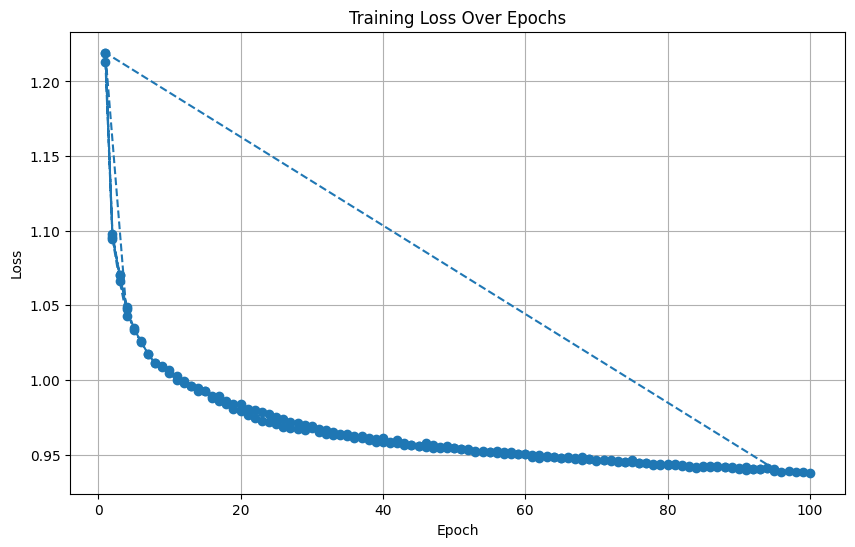

In [20]:
import matplotlib.pyplot as plt

# renaming the columns for more clarity to understand
csv_data_100k.columns = ['Epoch', 'Loss']
plt.figure(figsize=(10, 6))
plt.plot(csv_data_100k['Epoch'], csv_data_100k['Loss'], marker='o', linestyle='--')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [21]:
from sklearn.metrics import mean_squared_error, r2_score
import math

def calculate_rmse(y_true, y_pred):
    return math.sqrt(mean_squared_error(y_true, y_pred))

def calculate_r2(y_true, y_pred):
    return r2_score(y_true, y_pred)

In [23]:
model.eval() # Set the model to evaluation mode
all_predictions = []
all_true_values = []

with torch.no_grad(): # Disable gradient calculations
    for batch_Z, batch_R, batch_Q, batch_M, batch_y in dataloader:
        for Z, R, Q, M, y in zip(batch_Z, batch_R, batch_Q, batch_M, batch_y):
            Z = Z.to(device)
            R = R.to(device)
            Q = Q.to(device)
            M = M.to(device)
            y_pred = model(Z, R, Q, M)

            all_predictions.append(y_pred.item())
            all_true_values.append(y.item())

rmse = calculate_rmse(all_true_values, all_predictions)
r2 = calculate_r2(all_true_values, all_predictions)

print(f"The Mean Absolute Error (MAE) value after 100 epochs on a subset of 100000 data values is : {train_loss:.4f} eV")
print(f"The Root Mean Squared Error (RMSE) value after 100 epochs on a subset of 100000 data values is : {rmse:.4f} eV")
print(f"The R-squared (R²) value after 100 epochs on a subset of 100000 data values is: {r2:.4f}")

The Mean Absolute Error (MAE) value after 100 epochs on a subset of 100000 data values is : 0.9378 eV
The Root Mean Squared Error (RMSE) value after 100 epochs on a subset of 100000 data values is : 1.2364 eV
The R-squared (R²) value after 100 epochs on a subset of 100000 data values is: 0.4200


In [24]:
!pip install -q torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 19.2 MB/s eta 0:00:00


In [25]:
import torch
from torch_geometric.data import Data
from scipy.spatial import cKDTree
import numpy as np

def radius_graph(pos, radius=5.0):
    tree = cKDTree(pos)
    pairs = tree.query_pairs(radius)
    edge_index = []

    for i, j in pairs:
        edge_index.append([i, j])
        edge_index.append([j, i])

    if len(edge_index) == 0:
        edge_index = torch.empty((2, 0), dtype=torch.long)
    else:
        edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    return edge_index

def samples_to_pyg_data(samples, use_delta_learning=False):
    data_list = []
    for sample in samples:
        Z, R, Q_np_charges, M, gap_pbe0 = sample[:5]
        # Optionally assume samples have gfn2_gap as 6th element for Δ-learning
        gfn2_gap = sample[5] if (use_delta_learning and len(sample) > 5) else None

        edge_index = radius_graph(R)
        x = torch.tensor(Z, dtype=torch.long)
        pos = torch.tensor(R, dtype=torch.float32)
        Q = torch.tensor(Q_np_charges.sum(), dtype=torch.float32) # Fixed: sum of charges, making it a scalar per molecule
        M = torch.tensor([M], dtype=torch.float32)
        y = torch.tensor(gap_pbe0, dtype=torch.float32)  # Target gap

        data = Data(x=x, edge_index=edge_index, pos=pos, y=y)
        data.Q = Q
        data.M = M

        if use_delta_learning and gfn2_gap is not None:
            data.baseline_gap = torch.tensor(gfn2_gap, dtype=torch.float32)
        else:
            data.baseline_gap = torch.tensor(0.0, dtype=torch.float32)  # No baseline

        data_list.append(data)
    return data_list

In [26]:
import torch
from torch_geometric.nn import GINConv, global_mean_pool
from torch.nn import Linear, SiLU, Sequential, ReLU

class DeltaGraphModel(torch.nn.Module):
    def __init__(self, hidden_dim=128):
        super().__init__()
        self.embed_Z = torch.nn.Embedding(100, hidden_dim)
        nn1 = Sequential(
            Linear(hidden_dim, hidden_dim),
            ReLU(),
            Linear(hidden_dim, hidden_dim)
        )
        self.conv = GINConv(nn1)
        self.lin1 = Linear(hidden_dim + 2, 128)  # add Q and M
        self.lin_out = Linear(128, 1)
        self.act = SiLU()

    def forward(self, x, edge_index, batch, Q, M):
        h = self.embed_Z(x)
        h = self.conv(h, edge_index)
        h = global_mean_pool(h, batch)
        q_m = torch.cat([Q.unsqueeze(1), M.unsqueeze(1)], dim=1).to(h.device)
        h = torch.cat([h, q_m], dim=1)
        h = self.act(self.lin1(h))
        out = self.lin_out(h)
        return out.squeeze(-1)

In [28]:
### Step 3: Training loop for Δ-learning

from torch_geometric.loader import DataLoader
from torch.nn import L1Loss
from torch.optim import Adam

def train_delta_epoch(model, loader, optimizer, loss_fn, device):
    model.train()
    total_loss = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        pred_delta = model(data.x, data.edge_index, data.batch, data.Q, data.M)
        pred_gap = data.baseline_gap + pred_delta
        loss = loss_fn(pred_gap, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(loader.dataset)

# Example usage:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DeltaGraphModel(hidden_dim=128).to(device)
optimizer = Adam(model.parameters(), lr=1e-3)
loss_fn = L1Loss()

# Assuming samples is your dataset list, and contains gfn2_gap for delta-learning
data_list = samples_to_pyg_data(samples, use_delta_learning=True)
dataloader = DataLoader(data_list, batch_size=128, shuffle=True)



In [29]:
loss_fn_csv_100k_delta = "/content/drive/MyDrive/Colab Notebooks/ML_project_ksb/100k_loss_csv_delta"

# Check if Google Drive is mounted
if not os.path.exists('/content/drive'):
    print("Google Drive is not mounted. Please mount Google Drive to save the CSV file.")
    print("You can do this by running: from google.colab import drive; drive.mount('/content/drive')")
else:
    # Ensure the directory exists
    os.makedirs(os.path.dirname(loss_fn_csv_100k_delta), exist_ok=True)

    # Check if the CSV file exists; if not, create it with headers
    if not os.path.exists(loss_fn_csv_100k_delta):
        with open(loss_fn_csv_100k_delta, 'w', newline='') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow(['Epoch', 'Train Loss'])
        print(f"Created CSV file with headers: {loss_fn_csv_100k_delta}")
    else:
        print(f"CSV file already exists: {loss_fn_csv_100k_delta}")

Created CSV file with headers: /content/drive/MyDrive/Colab Notebooks/ML_project_ksb/100k_loss_csv_delta


In [30]:
for epoch in range(100):
    loss = train_delta_epoch(model, dataloader, optimizer, loss_fn, device)
    with open(loss_fn_csv_100k_delta, 'a', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow([epoch+1 , loss])
    print(f"Epoch {epoch+1}, Loss: {loss:.4f}")

Epoch 1, Loss: 1.1654
Epoch 2, Loss: 1.0592
Epoch 3, Loss: 1.0355
Epoch 4, Loss: 1.0198
Epoch 5, Loss: 1.0084
Epoch 6, Loss: 1.0007
Epoch 7, Loss: 0.9913
Epoch 8, Loss: 0.9829
Epoch 9, Loss: 0.9774
Epoch 10, Loss: 0.9685
Epoch 11, Loss: 0.9656
Epoch 12, Loss: 0.9611
Epoch 13, Loss: 0.9566
Epoch 14, Loss: 0.9518
Epoch 15, Loss: 0.9482
Epoch 16, Loss: 0.9441
Epoch 17, Loss: 0.9412
Epoch 18, Loss: 0.9401
Epoch 19, Loss: 0.9366
Epoch 20, Loss: 0.9320
Epoch 21, Loss: 0.9298
Epoch 22, Loss: 0.9280
Epoch 23, Loss: 0.9254
Epoch 24, Loss: 0.9230
Epoch 25, Loss: 0.9190
Epoch 26, Loss: 0.9184
Epoch 27, Loss: 0.9169
Epoch 28, Loss: 0.9156
Epoch 29, Loss: 0.9131
Epoch 30, Loss: 0.9123
Epoch 31, Loss: 0.9097
Epoch 32, Loss: 0.9078
Epoch 33, Loss: 0.9082
Epoch 34, Loss: 0.9056
Epoch 35, Loss: 0.9032
Epoch 36, Loss: 0.9030
Epoch 37, Loss: 0.9015
Epoch 38, Loss: 0.8988
Epoch 39, Loss: 0.8985
Epoch 40, Loss: 0.8979
Epoch 41, Loss: 0.8959
Epoch 42, Loss: 0.8951
Epoch 43, Loss: 0.8937
Epoch 44, Loss: 0.89

In [31]:
csv_data_100k_delta = pd.read_csv(loss_fn_csv_100k_delta)
csv_data_100k_delta.head()
#

,Epoch,Train Loss
0,1,1.165353
1,2,1.059169
2,3,1.035467
3,4,1.019772
4,5,1.008445


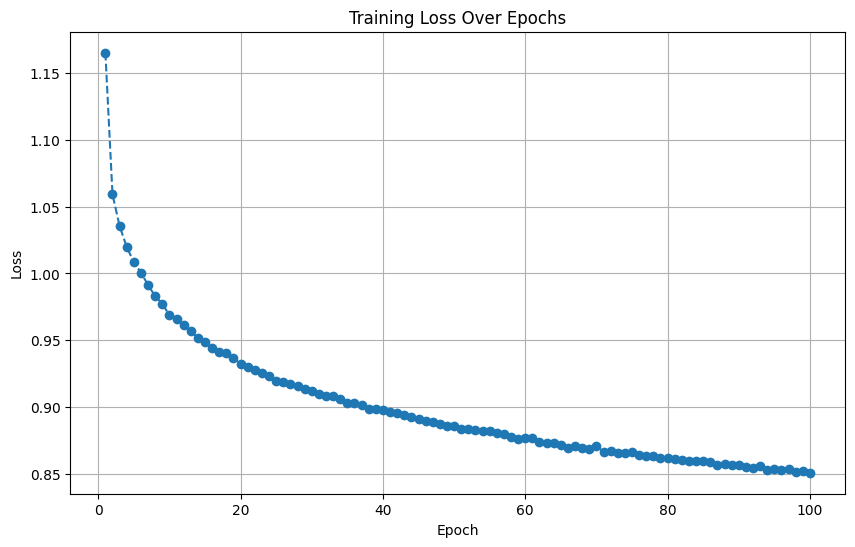

In [32]:
import matplotlib.pyplot as plt

# renaming the columns for more clarity to understand
csv_data_100k_delta.columns = ['Epoch', 'Loss']
plt.figure(figsize=(10, 6))
plt.plot(csv_data_100k_delta['Epoch'], csv_data_100k_delta['Loss'], marker='o', linestyle='--')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [33]:
model.eval() # Set the model to evaluation mode
all_predictions_delta = []
all_true_values_delta = []

with torch.no_grad(): # Disable gradient calculations
    for data in dataloader:
        data = data.to(device)
        pred_delta = model(data.x, data.edge_index, data.batch, data.Q, data.M)
        pred_gap = data.baseline_gap + pred_delta

        all_predictions_delta.extend(pred_gap.cpu().numpy())
        all_true_values_delta.extend(data.y.cpu().numpy())

rmse_delta = calculate_rmse(all_true_values_delta, all_predictions_delta)
r2_delta = calculate_r2(all_true_values_delta, all_predictions_delta)

print(f"The Mean Absolute Error (MAE) value after 100 epochs for the DeltaGraphModel is : {loss:.4f} eV")
print(f"The Root Mean Squared Error (RMSE) value for the DeltaGraphModel is : {rmse_delta:.4f} eV")
print(f"The R-squared (R²) value for the DeltaGraphModel is: {r2_delta:.4f}")

The Mean Absolute Error (MAE) value after 100 epochs for the DeltaGraphModel is : 0.8507 eV
The Root Mean Squared Error (RMSE) value for the DeltaGraphModel is : 1.1426 eV
The R-squared (R²) value for the DeltaGraphModel is: 0.5047


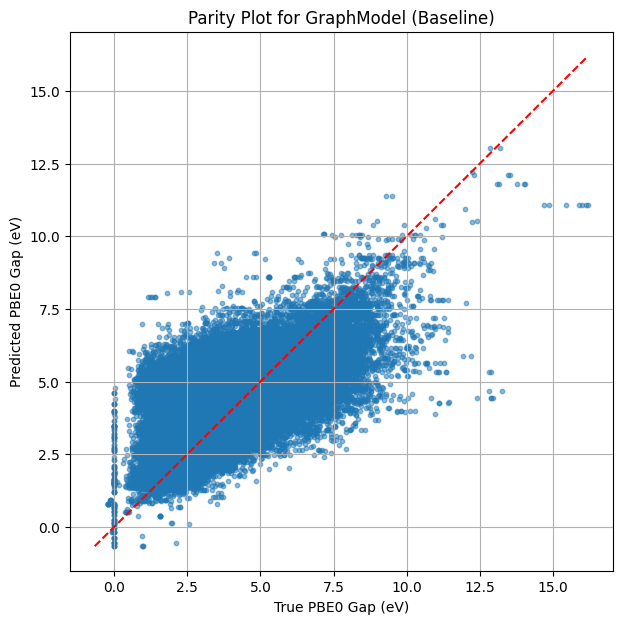

In [34]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(7, 7))

plt.scatter(all_true_values, all_predictions, s=10, alpha=0.5)

# diagonal reference line
min_val = min(min(all_true_values), min(all_predictions))
max_val = max(max(all_true_values), max(all_predictions))
plt.plot([min_val, max_val], [min_val, max_val], 'r--')

plt.xlabel("True PBE0 Gap (eV)")
plt.ylabel("Predicted PBE0 Gap (eV)")
plt.title("Parity Plot for GraphModel (Baseline)")
plt.grid(True)
plt.show()


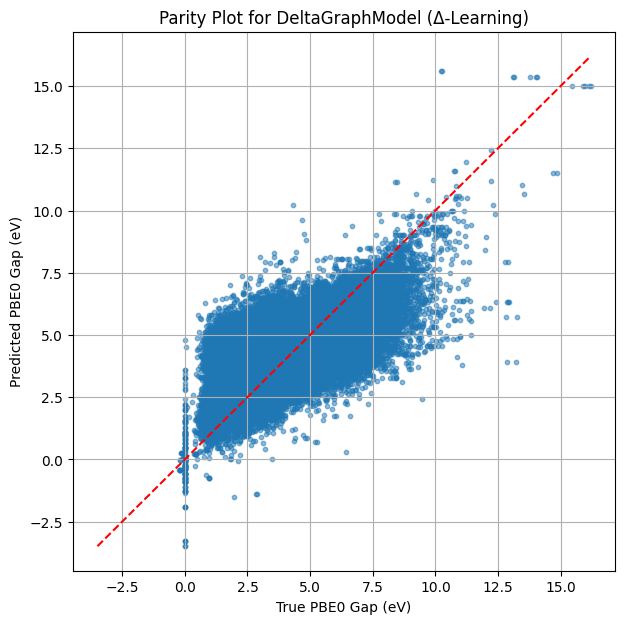

In [35]:
plt.figure(figsize=(7, 7))

plt.scatter(all_true_values_delta, all_predictions_delta, s=10, alpha=0.5)

min_val = min(min(all_true_values_delta), min(all_predictions_delta))
max_val = max(max(all_true_values_delta), max(all_predictions_delta))
plt.plot([min_val, max_val], [min_val, max_val], 'r--')

plt.xlabel("True PBE0 Gap (eV)")
plt.ylabel("Predicted PBE0 Gap (eV)")
plt.title("Parity Plot for DeltaGraphModel (Δ-Learning)")
plt.grid(True)
plt.show()
